In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install numpy==1.25.0
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.0 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.6/38.6 MB 255.5 MB/s eta 0:00:01^C


In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
dataset_path = "/content/drive/MyDrive/AI Level 6/racist/train_racisit.csv"
df = pd.read_csv(dataset_path)

In [3]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df.isnull().any()

,0
id,False
label,False
tweet,False


In [5]:
def text_processing_workflow(text_input, method="lemmatize"):
    """
    Processes input text by cleaning and transforming it based on the specified method.
    """
    # Convert text to lowercase
    processed_text = text_input.lower()
    # Remove URLs from text
    processed_text = re.sub(r"http\S+|www\S+|https\S+", '', processed_text, flags=re.MULTILINE)
    # Remove emojis from text
    processed_text = re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\u2702-\u27B0"          # dingbats
                           u"\u24C2-\U0001F251"      # enclosed characters
                           "]+",
                           r' ', processed_text, flags=re.UNICODE)
    # Remove user mentions
    processed_text = re.sub("@[A-Za-z0-9_]+", " ", processed_text)
    # Remove unwanted characters
    processed_text = re.sub("[^0-9A-Za-z ]", "", processed_text)
    # Split text into tokens
    word_tokens = processed_text.split()
    # Filter out stopwords
    stopword_list = set(stopwords.words('english'))
    filtered_tokens = []
    for word in word_tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    if method == "lemmatize":
        lemmatizer = WordNetLemmatizer()
        final_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    elif method == "stem":
        stemmer = PorterStemmer()
        final_tokens = [stemmer.stem(word) for word in filtered_tokens]
    else:
        print("Choose either lemmatize or stem")

    return " ".join(final_tokens)

In [6]:
df['processed_tweet'] = df['tweet'].apply(lambda x: text_processing_workflow(x, method="lemmatize"))

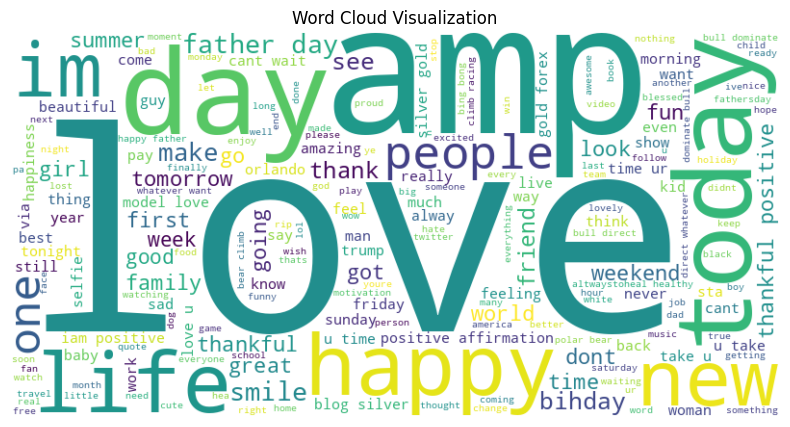

In [7]:
# Combine all cleaned tweets into a single string
combined_text = " ".join(df['processed_tweet'])
# Generate a word cloud visualization
word_cloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Visualization")
plt.show()

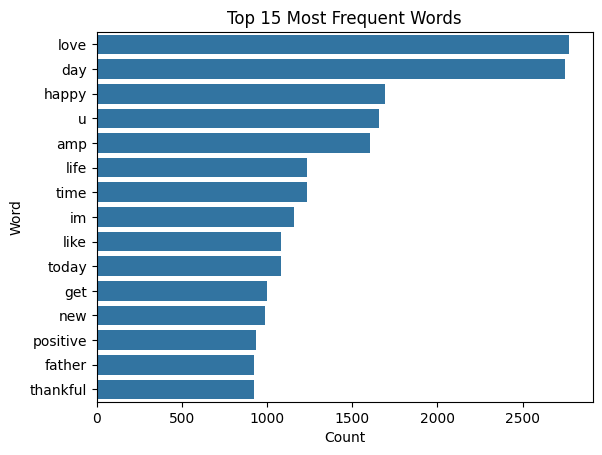

In [8]:
# Calculate word frequency
word_counts = Counter(" ".join(df["processed_tweet"]).split())
# Create a DataFrame with the top 15 most common words
top_words = pd.DataFrame(word_counts.most_common(15), columns=['Word', 'Count'])
# Plot a bar chart of the top 15 words
sns.barplot(data=top_words, x='Count', y='Word')
plt.title("Top 15 Most Frequent Words")
plt.show()

In [9]:
# Prepare features and labels for tokenization
texts = df['processed_tweet'].values
labels = df['label'].values

In [10]:
# Split data into training and validation sets
texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [11]:
import numpy as np
# Initialize tokenizer with out-of-vocabulary token
text_tokenizer = Tokenizer(oov_token="<OOV>")
text_tokenizer.fit_on_texts(texts_train)
total_vocab = len(text_tokenizer.word_index) + 1
print("Vocabulary size: ", total_vocab)

# Convert texts to sequences
train_sequences = text_tokenizer.texts_to_sequences(texts_train)
val_sequences = text_tokenizer.texts_to_sequences(texts_val)

# Calculate maximum sequence length based on 95th percentile
sequence_max_len = int(np.percentile([len(seq) for seq in train_sequences], 95))
print("\nMaximum Sequence Length: ", sequence_max_len)
# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=sequence_max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=sequence_max_len, padding='post')

Vocabulary size:  33695

Maximum Sequence Length:  13


In [12]:
def display_model_metrics(history, model_type):
    """
    Visualizes training and validation metrics for a given model.
    """
    plt.figure(figsize=(12, 6))
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_type}: Train vs Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_type}: Train vs Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [13]:
def assess_model_performance(model, model_type):
    """
    Evaluates the performance of a given model on validation data.
    """
    # Calculate validation loss and accuracy
    val_loss, val_accuracy = model.evaluate(val_padded, labels_val, verbose=0)
    print('Validation Loss:', val_loss)
    print('\nValidation Accuracy:', val_accuracy)
    # Predict labels for validation data
    predicted_labels = (model.predict(val_padded) > 0.5).astype(int)
    print(f"\n\n{model_type} Accuracy: {accuracy_score(labels_val, predicted_labels):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(labels_val, predicted_labels))
    print("Classification Report:\n", classification_report(labels_val, predicted_labels))

In [14]:
# Define early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# Save the best model during training
model_saver = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

In [15]:
# Build a simple RNN model
simple_rnn = Sequential([
    Embedding(input_dim=total_vocab, output_dim=64, input_length=sequence_max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
# Compile the model
simple_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build model with input shape
simple_rnn.build(input_shape=(None, sequence_max_len))
# Display model architecture
simple_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,164,801 (8.26 MB)

 Trainable params: 2,164,801 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the simple RNN model
simple_rnn_history = simple_rnn.fit(
    train_padded, labels_train,
    epochs=10,
    batch_size=64,
    validation_data=(val_padded, labels_val),
    callbacks=[stop_early, model_saver],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9280 - loss: 0.2465

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9280 - loss: 0.2464 - val_accuracy: 0.9540 - val_loss: 0.1408
Epoch 2/10
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9829 - loss: 0.0539

400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9829 - loss: 0.0539 - val_accuracy: 0.9557 - val_loss: 0.1313
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9954 - loss: 0.0155 - val_accuracy: 0.9381 - val_loss: 0.1934
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9984 - loss: 0.0066 - val_accuracy: 0.9528 - val_loss: 0.2015
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9521 - val_loss: 0.2005
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9489 - val_loss: 0.2138


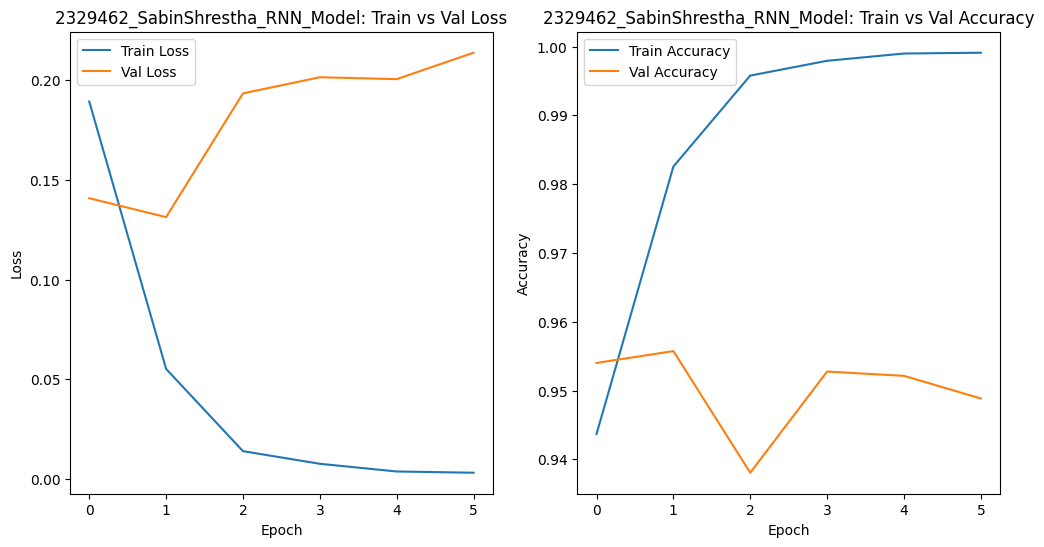

In [17]:
# Visualize training and validation metrics
display_model_metrics(simple_rnn_history, "2329462_SabinShrestha_RNN_Model")

In [18]:
# Evaluate model performance on validation data
assess_model_performance(simple_rnn, "2329462_SabinShrestha_RNN_Model")

Validation Loss: 0.13132542371749878

Validation Accuracy: 0.9557328224182129
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


2329462_SabinShrestha_RNN_Model Accuracy: 0.9557
Confusion Matrix:
 [[5837  100]
 [ 183  273]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5937
           1       0.73      0.60      0.66       456

    accuracy                           0.96      6393
   macro avg       0.85      0.79      0.82      6393
weighted avg       0.95      0.96      0.95      6393



In [19]:
# Save the trained model
simple_rnn.save('2329462_SabinShrestha_RNN_Model.h5')

Model 2: LSTM with Trainable Embedding Layer

In [20]:
# Build an LSTM model with trainable embedding
lstm_model = Sequential([
    Embedding(input_dim=total_vocab, output_dim=64, input_length=sequence_max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

# Compile the LSTM model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build model with input shape
lstm_model.build(input_shape=(None, sequence_max_len))
# Display model architecture
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,569 (8.35 MB)

 Trainable params: 2,189,569 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the LSTM model
lstm_model_history = lstm_model.fit(
    train_padded, labels_train,
    epochs=10,
    batch_size=64,
    validation_data=(val_padded, labels_val),
    callbacks=[stop_early, model_saver],
    verbose=1
)


Epoch 1/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9245 - loss: 0.2530

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9246 - loss: 0.2527 - val_accuracy: 0.9578 - val_loss: 0.1272
Epoch 2/10
391/400 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9793 - loss: 0.0656

400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9793 - loss: 0.0656 - val_accuracy: 0.9607 - val_loss: 0.1158
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9927 - loss: 0.0267 - val_accuracy: 0.9593 - val_loss: 0.1452
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9956 - loss: 0.0159 - val_accuracy: 0.9612 - val_loss: 0.1753
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9975 - loss: 0.0101 - val_accuracy: 0.9565 - val_loss: 0.1845
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 0.9524 - val_loss: 0.2054


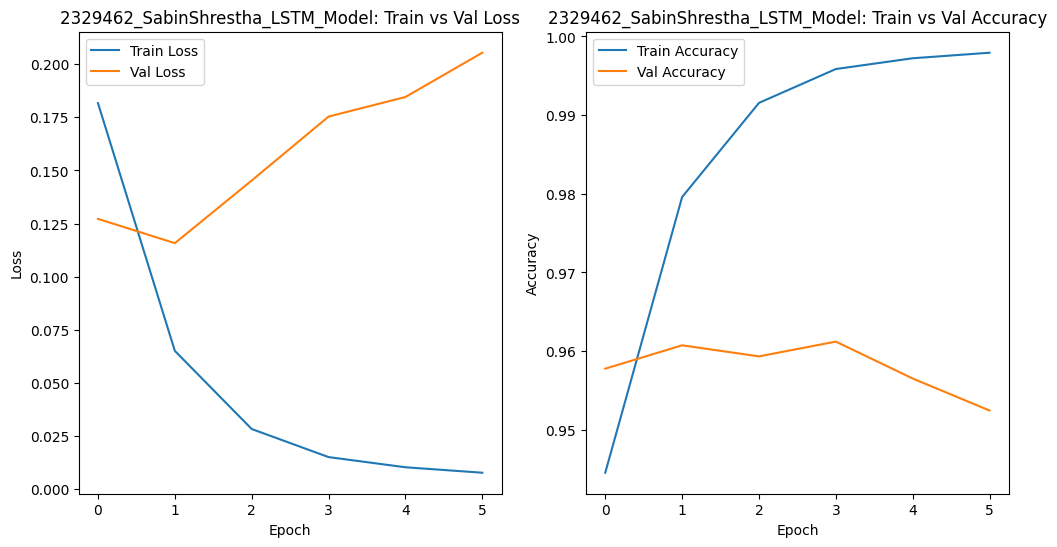

In [22]:
# Visualize training and validation metrics
display_model_metrics(lstm_model_history, "2329462_SabinShrestha_LSTM_Model")

In [23]:
# Evaluate model performance on validation data
assess_model_performance(lstm_model, "2329462_SabinShrestha_LSTM_Model")

Validation Loss: 0.11577755957841873

Validation Accuracy: 0.9607383012771606
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2329462_SabinShrestha_LSTM_Model Accuracy: 0.9607
Confusion Matrix:
 [[5845   92]
 [ 159  297]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      5937
           1       0.76      0.65      0.70       456

    accuracy                           0.96      6393
   macro avg       0.87      0.82      0.84      6393
weighted avg       0.96      0.96      0.96      6393



In [24]:
# Save the trained model
lstm_model.save('2329462_SabinShrestha_LSTM_Model.h5')

Model 3: LSTM with Pre Trained Word2Vec Embeddings

In [25]:
!pip install gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [26]:
import gensim.downloader as api
!ls

2329462_SabinShrestha_LSTM_Model.h5  best_model.h5  sample_data
2329462_SabinShrestha_RNN_Model.h5   drive


In [27]:
# Load pre-trained Word2Vec embedding model
pretrained_embeddings = api.load('glove-wiki-gigaword-50')
embedding_size = 50
# Initialize embedding matrix
embedding_weights = np.zeros((total_vocab, embedding_size))
for word, index in text_tokenizer.word_index.items():
    if word in pretrained_embeddings:
        embedding_weights[index] = pretrained_embeddings[word]

[==================================================] 100.0% 66.0/66.0MB downloaded


In [28]:
# Build an LSTM model with pre-trained embeddings
lstm_model02 = Sequential([
    Embedding(input_dim=total_vocab, output_dim=embedding_size, input_length=sequence_max_len,
              weights=[embedding_weights], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])


# Compile the LSTM model
lstm_model02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Display model architecture
lstm_model02.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,684,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,750 (6.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,684,750 (6.43 MB)

In [29]:
# Train the LSTM model
lstm_model02_history = lstm_model02.fit(
    train_padded, labels_train,
    epochs=10,
    batch_size=64,
    validation_data=(val_padded, labels_val),
    callbacks=[stop_early, model_saver],
    verbose=1
)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9334 - loss: 0.2420 - val_accuracy: 0.9393 - val_loss: 0.1765
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9415 - loss: 0.1632 - val_accuracy: 0.9473 - val_loss: 0.1503
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9502 - loss: 0.1414 - val_accuracy: 0.9485 - val_loss: 0.1426
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9559 - loss: 0.1283 - val_accuracy: 0.9484 - val_loss: 0.1537
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9585 - loss: 0.1200 - val_accuracy: 0.9495 - val_loss: 0.1370
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9643 - loss: 0.1080 - val_accuracy: 0.9528 - val_loss: 0.1373
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9677 - loss: 0.0967 - val_accuracy: 0.9528 - val_loss: 0.1348
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9698 - loss: 0.0893 - val_accuracy: 0.

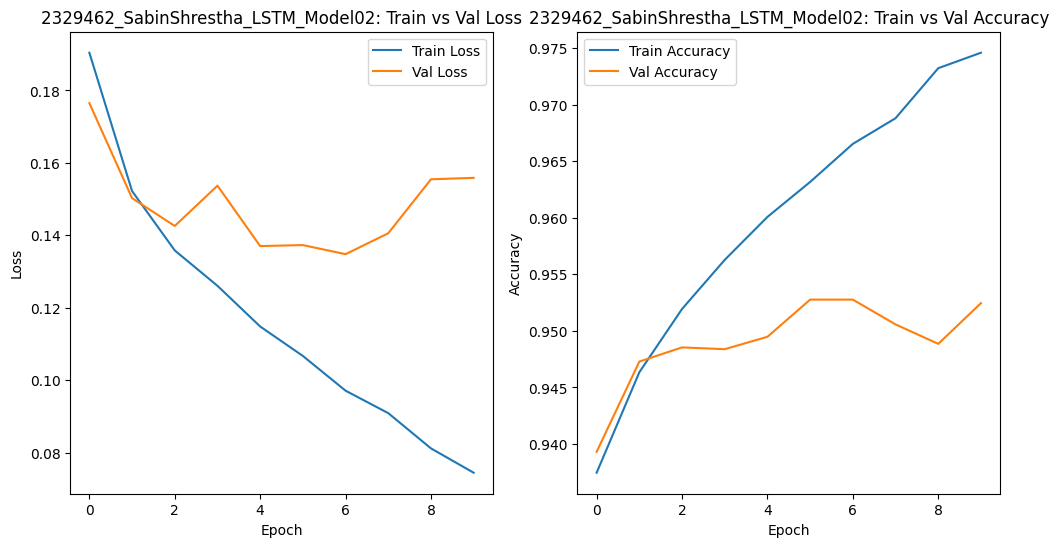

In [30]:
# Visualize training and validation metrics
display_model_metrics(lstm_model02_history, "2329462_SabinShrestha_LSTM_Model02")

In [31]:
# Evaluate model performance on validation data
assess_model_performance(lstm_model02, "2329462_SabinShrestha_LSTM_Model02")


Validation Loss: 0.13477618992328644

Validation Accuracy: 0.9527608156204224
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2329462_SabinShrestha_LSTM_Model02 Accuracy: 0.9528
Confusion Matrix:
 [[5860   77]
 [ 225  231]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      5937
           1       0.75      0.51      0.60       456

    accuracy                           0.95      6393
   macro avg       0.86      0.75      0.79      6393
weighted avg       0.95      0.95      0.95      6393



In [32]:
# Save the trained model
lstm_model02.save('2329462_SabinShrestha_LSTM_Model02.h5')

Predictions

In [33]:
# Initialize lemmatizer and stop words
word_lemmatizer = WordNetLemmatizer()
stopword_set = set(stopwords.words('english'))

def process_text(input_text):
    """
    Cleans and processes input text by lowercasing, removing URLs, mentions, hashtags, digits, punctuation, stop words, and lemmatizing.
    """
    # Convert to lowercase
    processed_text = input_text.lower()
    # Remove URLs, mentions, hashtags, and digits
    processed_text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", '', processed_text)
    # Remove punctuation
    processed_text = re.sub(rf"[{re.escape(string.punctuation)}]", '', processed_text)
    # Remove stop words
    processed_text = re.sub(r"\b(?:{})\b".format('|'.join(stopword_set)), '', processed_text)
    # Lemmatize words and join
    processed_text = " ".join([word_lemmatizer.lemmatize(word) for word in processed_text.split()])
    return processed_text.strip()

In [34]:
# Predict sentiment for custom text
def classify_text(model, model_type, text):
    """
    Predicts sentiment for a given text using the specified model.
    """
    # Clean the input text
    cleaned_text = process_text(text)
    # Convert to sequence
    sequence = text_tokenizer.texts_to_sequences([cleaned_text])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=sequence_max_len, padding='post')
    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]
    # Determine sentiment
    sentiment_label = 'Racist/Sexist' if prediction > 0.5 else 'Not Racist/Sexist'
    print(f"\nPrediction made by model: {model_type}\n")
    print(f"Text: {text}\nPrediction: {sentiment_label} ({prediction:.3f})")

In [35]:
classify_text(
    simple_rnn,
    "2329462_SabinShrestha_RNN_Model",
    "food time for haylie 😛 hot chocolate for mummy ☕️❜🌤🍃💯💪⚰🙓 thank god it's friday!!! 🙏🙏🙏 …"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step

Prediction made by model: 2329462_SabinShrestha_RNN_Model

Text: food time for haylie 😛 hot chocolate for mummy ☕️❜🌤🍃💯💪⚰🙓 thank god it's friday!!! 🙏🙏🙏 …
Prediction: Not Racist/Sexist (0.024)


In [36]:
# LSTM Model Prediction
classify_text(lstm_model, "2329462_SabinShrestha_LSTM_Model",
              "enjoying the sunshine! god is good. #orlando #sunshinestate #goodlife #bosslady #joy  â¦")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Prediction made by model: 2329462_SabinShrestha_LSTM_Model

Text: enjoying the sunshine! god is good. #orlando #sunshinestate #goodlife #bosslady #joy  â¦
Prediction: Not Racist/Sexist (0.003)


In [37]:
# LSTM Model with Word2Vec Prediction
classify_text(lstm_model02, "2329462_SabinShrestha_LSTM_Model02",
              "time for a pint before seeing coldplay in wembleyyyy ð³ðð   #coldplay #wembleystadiumâ¦")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Prediction made by model: 2329462_SabinShrestha_LSTM_Model02

Text: time for a pint before seeing coldplay in wembleyyyy ð³ðð   #coldplay #wembleystadiumâ¦
Prediction: Not Racist/Sexist (0.005)


In [38]:
import pickle
# Save the tokenizer for future use
with open('text_tokenizer.pickle', 'wb') as handle:
    pickle.dump(text_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
!pip install gradio
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the models
models = {
    "Simple RNN": simple_rnn,
    "LSTM": lstm_model,
    "W2VLSTM": lstm_model02
}

def predict_hate_speech(text, model_choice):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    model = models[model_choice]
    pred = model.predict(pad)[0][0]
    sentiment = "🟥 Racist/Sexist" if pred > 0.5 else "🟩 Not Racist/Sexist"
    confidence = pred if pred > 0.5 else 1 - pred
    return f"{sentiment}\nConfidence: {confidence:.2%}"

gr.Interface(
    fn=predict_hate_speech,
    inputs=[
        gr.Textbox(placeholder="Enter a tweet...", lines=2),
        gr.Dropdown(choices=["Simple RNN", "LSTM", "W2VLSTM"], label="Select Model")
    ],
    outputs="text",
    title="Tweet Classifier",
    description="Enter a tweet and select a model to detect if it's racist/sexist or not."
).launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1e1346b5ab0bba5541.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working director